In [645]:
import pandas as pd
import matplotlib.pyplot as plt

In [646]:
train = pd.read_excel("BBDD_PD.xlsx")
test = pd.read_excel("BBDD_PD.xlsx", sheet_name="Escenarios proyectados")


1. Estimación de un modelo macroeconómico:

In [647]:
train.rename(columns={"Tasa incumplimiento": "Tasa_incumplimiento"}, inplace=True)
test.rename(columns={"Tasa incumplimiento": "Tasa_incumplimiento"}, inplace=True)

1.1 SARIMAX

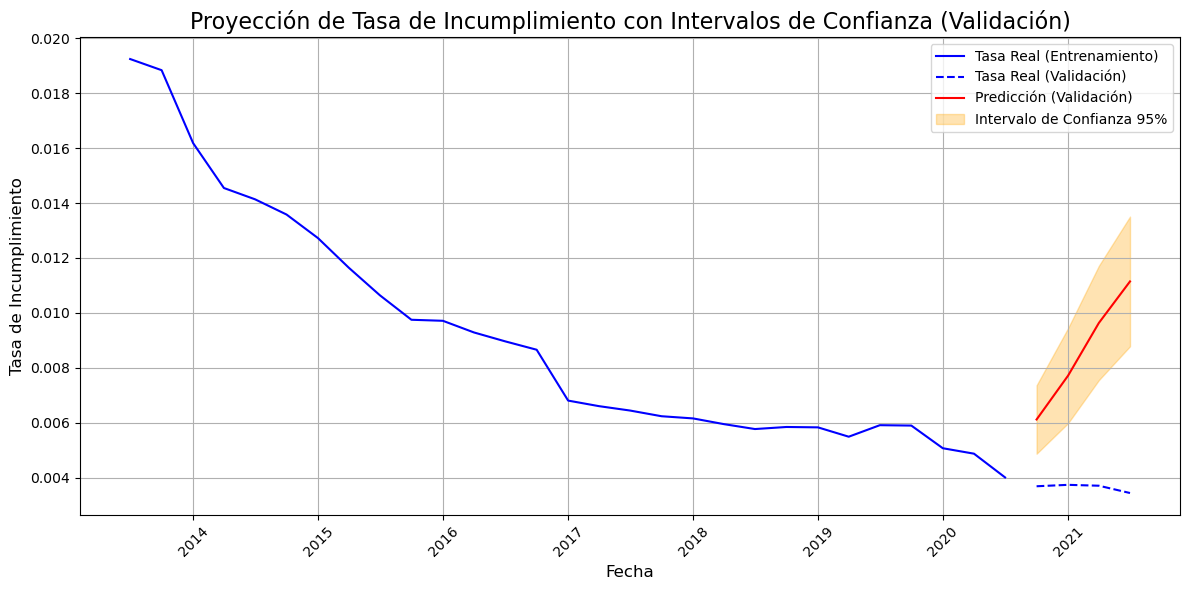

In [648]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Asegúrate de que los datos están correctamente formateados y ordenados
train["FECHA"] = pd.to_datetime(train["FECHA"])
train.set_index("FECHA", inplace=True)
train = train.asfreq("Q")

# Dividir los datos en entrenamiento y validación
train_train = train.iloc[:29]  # Primeras 29 filas para entrenar
train_test = train.iloc[29:]   # Resto de las filas para validar

# Variables dependientes e independientes
y_train = train_train["Tasa_incumplimiento"]
X_train = train_train[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

y_test = train_test["Tasa_incumplimiento"]
X_test = train_test[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

# Definir el modelo SARIMAX
sarimax_model = SARIMAX(
    endog=y_train,  # Variable dependiente
    exog=X_train,   # Variables independientes
    order=(1, 1, 1),  # Parámetros ARIMA (p, d, q)
    seasonal_order=(1, 0, 1, 4),  # Parámetros estacionales (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_results = sarimax_model.fit(disp=False)

# Realizar predicciones sobre el conjunto de validación (train_test)
forecast = sarimax_results.get_prediction(
    start=train_test.index[0], 
    end=train_test.index[-1], 
    exog=X_test,  # Exógenas para el conjunto de validación
    dynamic=False  # Asegúrate de que no se utilicen predicciones dinámicas
)

# Obtener las predicciones y los intervalos de confianza
predicted_mean = forecast.predicted_mean  # Predicciones puntuales
conf_int = forecast.conf_int()  # Intervalos de confianza al 95%

# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(12, 6))

# Valores reales
plt.plot(train_train.index, train_train["Tasa_incumplimiento"], color='blue', label='Tasa Real (Entrenamiento)')
plt.plot(train_test.index, train_test["Tasa_incumplimiento"], color='blue', linestyle="--", label='Tasa Real (Validación)')

# Predicciones puntuales
plt.plot(train_test.index, predicted_mean, color='red', label='Predicción (Validación)')

# Intervalos de confianza al 95%
plt.fill_between(train_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confianza 95%')

# Configuración del gráfico
plt.title('Proyección de Tasa de Incumplimiento con Intervalos de Confianza (Validación)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Tasa de Incumplimiento', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()



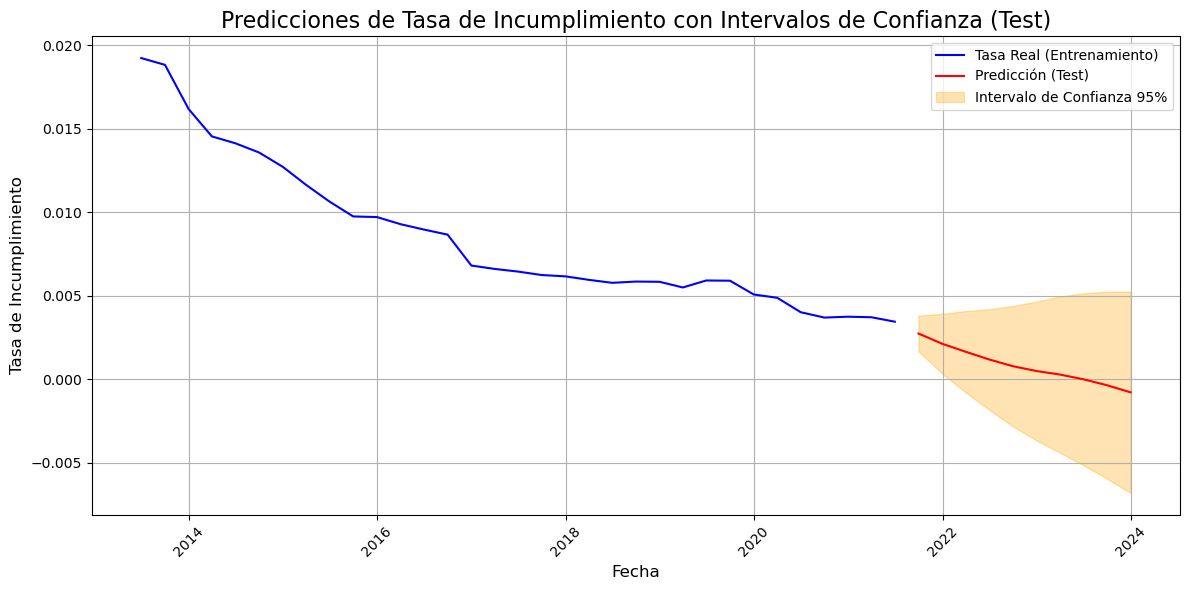

In [649]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Preprocesar los datos
test["FECHA"] = pd.to_datetime(test["FECHA"])
test.set_index("FECHA", inplace=True)
test = test.asfreq("Q")

# Utilizar los datos de entrenamiento completos (train) y el conjunto de test (test)
y_train = train["Tasa_incumplimiento"]
X_train = train[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

# Variables exógenas para test
X_test = test[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

# Definir y ajustar el modelo SARIMAX con los datos de entrenamiento
sarimax_model = SARIMAX(
    endog=y_train,  # Variable dependiente (tasa de incumplimiento)
    exog=X_train,   # Variables exógenas (Paro, PIB, Precio_vivienda, Mora_Adq_Vivienda)
    order=(1, 1, 1),  # Parámetros ARIMA (p, d, q)
    seasonal_order=(1, 0, 1, 4),  # Estacionalidad con frecuencia trimestral (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_results = sarimax_model.fit(disp=False)

# Realizar predicciones sobre el conjunto de test
forecast = sarimax_results.get_prediction(
    start=test.index[0], 
    end=test.index[-1], 
    exog=X_test,  # Exógenas para el conjunto de test
    dynamic=False  # Predicciones no dinámicas
)

# Obtener las predicciones puntuales y los intervalos de confianza
predicted_mean = forecast.predicted_mean # Predicciones puntuales
conf_int = forecast.conf_int(0.95)  # Intervalos de confianza 

# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(12, 6))

# Valores reales del conjunto de test (si los tienes)
if 'Tasa_incumplimiento' in test.columns:
    plt.plot(test.index, test["Tasa_incumplimiento"], color='blue', label='Tasa Real (Test)')

# Predicciones puntuales
plt.plot(train.index, train["Tasa_incumplimiento"], color='blue', label='Tasa Real (Entrenamiento)')


plt.plot(test.index, predicted_mean, color='red', label='Predicción (Test)')

# Intervalos de confianza al 95%
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confianza 95%')

# Configuración del gráfico
plt.title('Predicciones de Tasa de Incumplimiento con Intervalos de Confianza (Test)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Tasa de Incumplimiento', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Exportar el DataFrame test con las predicciones y los intervalos de confianza (opcional)
test["Predicciones"] = predicted_mean
test["Conf_int_lower"] = conf_int.iloc[:, 0]
test["Conf_int_upper"] = conf_int.iloc[:, 1]


c:\Users\emarc\anaconda3\envs\bdata3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


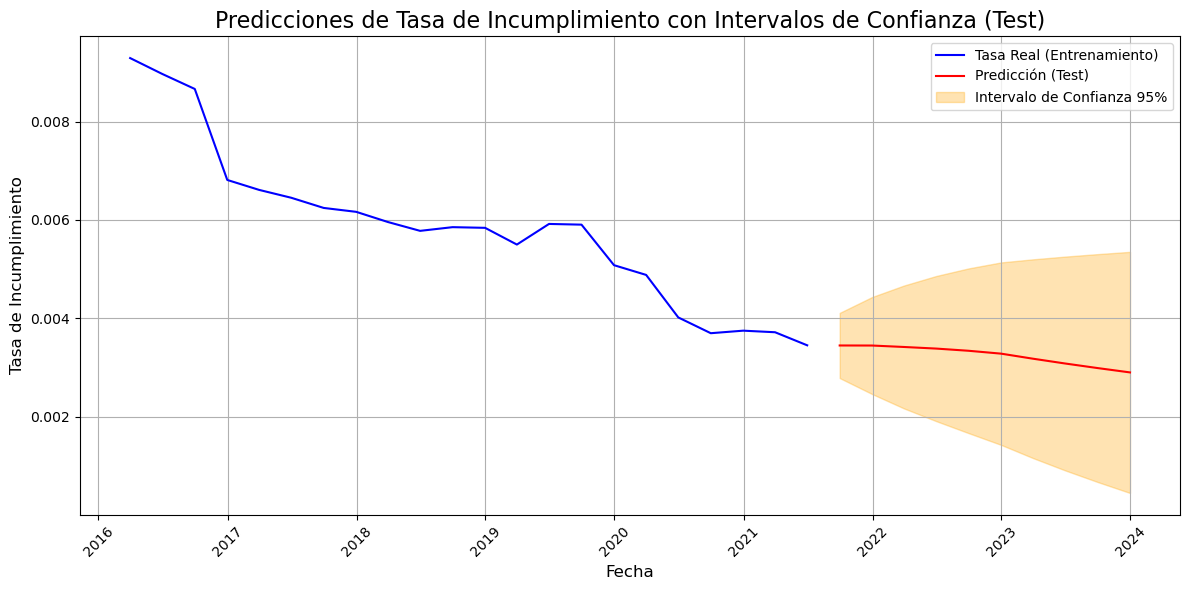

In [651]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = train[11:]

# Utilizar los datos de entrenamiento completos (train) y el conjunto de test (test)
y_train = train["Tasa_incumplimiento"]
X_train = train[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

# Variables exógenas para test
X_test = test[["Paro", "PIB", "Precio_vivienda", "Mora_Adq_Vivienda"]]

# Definir y ajustar el modelo SARIMAX con los datos de entrenamiento
sarimax_model = SARIMAX(
    endog=y_train,  # Variable dependiente (tasa de incumplimiento)
    exog=X_train,   # Variables exógenas (Paro, PIB, Precio_vivienda, Mora_Adq_Vivienda)
    order=(1, 1, 1),  # Parámetros ARIMA (p, d, q)
    seasonal_order=(0, 0, 0, 4),  # Estacionalidad con frecuencia trimestral (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo
sarimax_results = sarimax_model.fit(disp=False)

# Realizar predicciones sobre el conjunto de test
forecast = sarimax_results.get_prediction(
    start=test.index[0], 
    end=test.index[-1], 
    exog=X_test,  # Exógenas para el conjunto de test
    dynamic=False  # Predicciones no dinámicas
)

# Obtener las predicciones puntuales y los intervalos de confianza
predicted_mean = forecast.predicted_mean  # Predicciones puntuales
conf_int = forecast.conf_int(0.95)  # Intervalos de confianza 

# Ajustar para evitar predicciones igual a 0 (si la predicción es 0, poner un valor pequeño)
predicted_mean = predicted_mean.apply(lambda x: max(x, 1e-5))  # Evitar valores exactamente en 0

# Graficar las predicciones y los intervalos de confianza
plt.figure(figsize=(12, 6))

# Valores reales del conjunto de test (si los tienes)
if 'Tasa_incumplimiento' in test.columns:
    plt.plot(test.index, test["Tasa_incumplimiento"], color='blue', label='Tasa Real (Test)')

# Predicciones puntuales
plt.plot(train.index, train["Tasa_incumplimiento"], color='blue', label='Tasa Real (Entrenamiento)')
plt.plot(test.index, predicted_mean, color='red', label='Predicción (Test)')

# Intervalos de confianza al 95%
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3, label='Intervalo de Confianza 95%')

# Configuración del gráfico
plt.title('Predicciones de Tasa de Incumplimiento con Intervalos de Confianza (Test)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Tasa de Incumplimiento', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

# Exportar el DataFrame `test` con las predicciones y los intervalos de confianza (opcional)
test["Predicciones"] = predicted_mean
test["Conf_int_lower"] = conf_int.iloc[:, 0]
test["Conf_int_upper"] = conf_int.iloc[:, 1]


In [653]:
test

,Paro,PIB,Precio_vivienda,Mora_Adq_Vivienda,Predicciones,Conf_int_lower,Conf_int_upper
FECHA,,,,,,,
2021-09-30,0.145786,105.201662,1657.860334,0.029578,0.003447,0.002784,0.004110
2021-12-31,0.139232,106.884889,1666.566146,0.028849,0.003446,0.002459,0.004433
2022-03-31,0.132973,107.953737,1675.262287,0.028419,0.003416,0.002167,0.004666
2022-06-30,0.126995,109.033275,1684.003804,0.028275,0.003384,0.001909,0.004859
2022-09-30,0.121286,109.905541,1692.790935,0.028413,0.003339,0.001664,0.005014
2022-12-31,0.118560,110.564974,1701.623917,0.028838,0.003281,0.001426,0.005136
2023-03-31,0.119746,111.007234,1713.684554,0.029562,0.003178,0.001158,0.005198
2023-06-30,0.120344,111.673278,1725.830673,0.030606,0.003081,0.000907,0.005254
2023-09-30,0.120645,112.566664,1738.062881,0.032005,0.002988,0.000671,0.005304


----